In [2]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Review dataset and build image loading function

Load images into TF data pipeline

In [3]:
images = tf.data.Dataset.list_files('data\\a\\images\\*.jpg')

In [4]:
images.as_numpy_iterator().next()

b'data\\a\\images\\ac956ea99-9002-11ed-9427-089798be260c.jpg'

In [5]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_img)

In [7]:
images.as_numpy_iterator().next()

array([[[249, 251, 250],
        [249, 251, 250],
        [249, 251, 250],
        ...,
        [ 23,  36,  29],
        [ 30,  43,  36],
        [ 35,  50,  43]],

       [[249, 251, 250],
        [249, 251, 250],
        [249, 251, 250],
        ...,
        [ 24,  35,  29],
        [ 32,  45,  38],
        [ 37,  52,  45]],

       [[249, 251, 250],
        [249, 251, 250],
        [249, 251, 250],
        ...,
        [ 27,  38,  32],
        [ 39,  52,  45],
        [ 44,  57,  50]],

       ...,

       [[ 15,  26,  32],
        [ 14,  25,  31],
        [ 12,  25,  31],
        ...,
        [ 31,  58,  75],
        [ 30,  57,  74],
        [ 30,  57,  74]],

       [[ 12,  22,  31],
        [ 13,  23,  32],
        [ 11,  24,  30],
        ...,
        [ 32,  59,  76],
        [ 31,  58,  75],
        [ 32,  59,  76]],

       [[ 12,  22,  31],
        [ 14,  24,  33],
        [ 12,  25,  31],
        ...,
        [ 33,  60,  77],
        [ 34,  61,  78],
        [ 36,  63,  80]]

In [8]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

In [10]:
plot_images = image_generator.next()

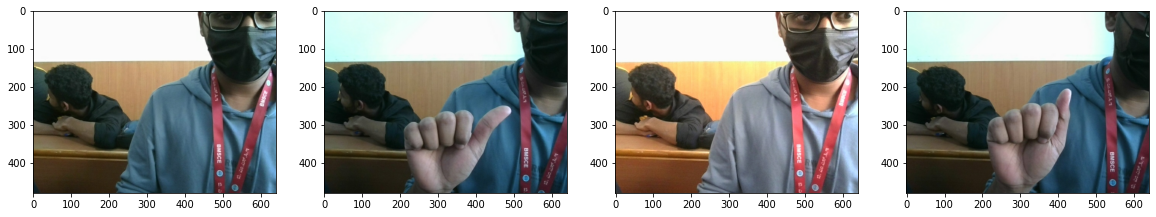

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)


## Partition unaugmented data

Divide images manually into train, test, val

Move matching labels into respective folders

In [12]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\train\\images'

## Apply image augmentation

In [13]:
import albumentations as alb

In [14]:
img = cv2.imread(os.path.join('data','a','images','ac7b8bcb0-9002-11ed-9dd3-089798be260c.jpg'))
img.shape

(480, 640, 3)

In [15]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2)
],bbox_params=alb.BboxParams(
    format='albumentations',
    label_fields=['class_labels']
))

In [16]:
img = cv2.imread(os.path.join('data','n','images','n75ee1d40-901a-11ed-86ad-089798be260c.jpg'))
with open(os.path.join('data','n','labels','n75ee1d40-901a-11ed-86ad-089798be260c.json'),'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[281.28205128205127, 114.87179487179488],
 [443.8461538461539, 287.69230769230774]]

## Apply augmentation

In [18]:
for partition in os.listdir(os.path.join('data')):
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f"{image.split('.')[0]}.json")
        
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}.{x}.jpg"), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition,'labels',f"{image.split('0')[0]}.{x}.json"),'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.23838141025641027, 0.08547008547008547, 0.0, 0.5602339004461646, 'face'].
x_max is less than or equal to x_min for bbox [0.34655448717948717, 0.09294871794871797, 0.0, 0.6131629591894493, 'face'].
x_max is less than or equal to x_min for bbox [0.6141826923076923, 0.11752136752136753, 0.26963141025641024, 0.8066239316239316, 'face'].
y_max is less than or equal to y_min for bbox [0.24959935897435898, 0.857905982905983, 0.5845352564102564, 0.1260683760683761, 'face'].
y_max is less than or equal to y_min for bbox [0.30248397435897434, 0.8504273504273505, 0.6454326923076923, 0.19230769230769232, 'face'].
x_max is less than or equal to x_min for bbox [0.48998397435897445, 0.8450854700854702, 0.13181089743589744, 0.18055555555555555, 'face'].
x_max is less than or equal to x_min for bbox [0.5316506410256411, 0.857905982905983, 0.19591346153846154, 0.1794871794871795, 'face'].
x_max is less than or equal to x_min for bbox [0.9002403846153847, 

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data\\a\\images\\*.jpg',shuffle=False)
for folder in os.listdir(os.path.join('aug_data'))[1:]:
    temp = tf.data.Dataset.list_files(f'aug_data\\{folder}\\images\\*.jpg', shuffle=False)
    train_images = train_images.concatenate(temp)
    
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
b
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
c
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
d
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
e
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
f
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=N

In [ ]:
# train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
# train_images = train_images.map(load_img)
# train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
# train_images = train_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.40900734, 0.3153799 , 0.2276348 ],
        [0.4259804 , 0.3413603 , 0.25784314],
        [0.45625   , 0.38125   , 0.30061275]],

       [[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.37493873, 0.28952205, 0.19840686],
        [0.43229166, 0.3598652 , 0.27169117],
        [0.46746323, 0.39142156, 0.30042893]],

       [[0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.44822302, 0.3403799 , 0.253125  ],
        [0.46072304, 0.3602941 , 0.27003676],
        [0.46813726, 0.37156862, 0.28480393]],

       ...,

       [[0.37175244, 0.18351716, 0.09332108],
        [0.36648285, 0.17922795, 0.08854166],
        [0.39411765, 0

## Prepare Labels

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files(f'aug_data\\a\\labels\\*.json', shuffle=False)
for folder in os.listdir(os.path.join('aug_data'))[1:]:
    train_labels = train_labels.concatenate(tf.data.Dataset.list_files(f'aug_data\\{folder}\\labels\\*.json', shuffle=False))

train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
# train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

## Combine Label and Image Samples

In [ ]:
len(train_images), len(train_labels)

(9420, 9000)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.4104  , 0.3367  , 0.781   , 0.812   ],
        [0.01761 , 0.2114  , 0.4473  , 0.9307  ],
        [0.2554  , 0.1975  , 0.709   , 0.943   ],
        [0.6235  , 0.2122  , 1.      , 0.6826  ],
        [0.      , 0.1602  , 0.3516  , 0.8555  ],
        [0.007866, 0.1696  , 0.449   , 1.      ],
        [0.624   , 0.4353  , 0.958   , 0.743   ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


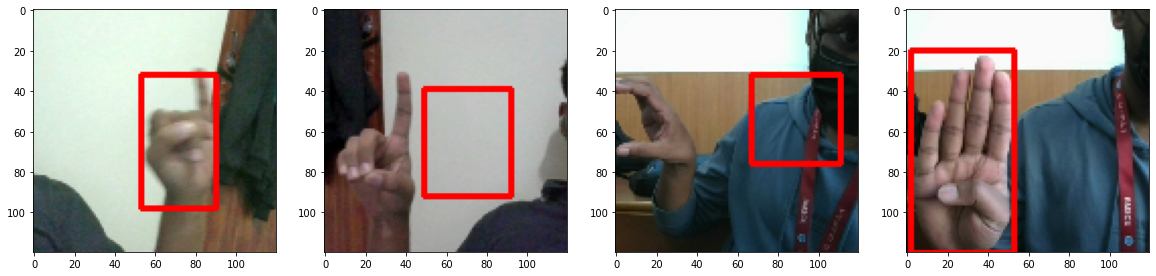

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

In [ ]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(25, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 4s 4s/step


In [ ]:
classes, coords

(array([[0.02146068, 0.05555753, 0.04453618, 0.05848627, 0.03002129,
         0.03497877, 0.06815048, 0.03315142, 0.06066433, 0.0558173 ,
         0.04162175, 0.04839735, 0.01736346, 0.03657652, 0.03309707,
         0.03760881, 0.02195464, 0.01093775, 0.02414406, 0.04234393,
         0.09590772, 0.03673833, 0.02605188, 0.02573805, 0.03869446],
        [0.01772956, 0.04940782, 0.03530343, 0.04582554, 0.0382252 ,
         0.02271873, 0.08196762, 0.03121487, 0.06325828, 0.04995551,
         0.04415689, 0.05174936, 0.01692795, 0.04571014, 0.0355879 ,
         0.03606702, 0.03873362, 0.01251222, 0.01584094, 0.03527481,
         0.12418482, 0.02783323, 0.01720808, 0.02331659, 0.03928985],
        [0.02010921, 0.04893582, 0.02544837, 0.04500638, 0.03591633,
         0.03324703, 0.0674928 , 0.02978198, 0.06286269, 0.05288697,
         0.04013554, 0.04008928, 0.02139661, 0.03631236, 0.02420402,
         0.04565606, 0.03024868, 0.02118748, 0.01400862, 0.04050994,
         0.10662445, 0.02863201,

## Define Losses and Optimizers

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.9907675>

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=3.3422148>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.9907675>

## Train Neural Network

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
1125/1125 [==============================] - 110s 91ms/step - total_loss: 2.0203 - class_loss: 3.1780 - regress_loss: 0.4313
Epoch 2/10
1125/1125 [==============================] - 105s 87ms/step - total_loss: 1.8994 - class_loss: 3.1767 - regress_loss: 0.3111
Epoch 3/10
1125/1125 [==============================] - 101s 85ms/step - total_loss: 1.8761 - class_loss: 3.1763 - regress_loss: 0.2880
Epoch 4/10
1125/1125 [==============================] - 103s 86ms/step - total_loss: 1.8680 - class_loss: 3.1766 - regress_loss: 0.2797
Epoch 5/10
1125/1125 [==============================] - 101s 85ms/step - total_loss: 1.8627 - class_loss: 3.1766 - regress_loss: 0.2744
Epoch 6/10
1125/1125 [==============================] - 99s 84ms/step - total_loss: 1.8546 - class_loss: 3.1766 - regress_loss: 0.2663
Epoch 7/10
1125/1125 [==============================] - 103s 86ms/step - total_loss: 1.8487 - class_loss: 3.1766 - regress_loss: 0.2604
Epoch 8/10
1125/1125 [===========================

In [ ]:
hist.history

{'total_loss': [2.109138250350952,
  2.0831286907196045,
  1.8304946422576904,
  1.7446887493133545,
  1.8818780183792114,
  1.8896452188491821,
  1.701940894126892,
  1.7633709907531738,
  1.9176394939422607,
  1.8490092754364014],
 'class_loss': [3.2191267013549805,
  3.21897029876709,
  2.821707010269165,
  3.2189362049102783,
  3.2189297676086426,
  3.2189230918884277,
  3.2188940048217773,
  3.2189011573791504,
  3.2188947200775146,
  3.2188940048217773],
 'regress_loss': [0.4995749592781067,
  0.47364360094070435,
  0.4196411073207855,
  0.1352206915616989,
  0.27241310477256775,
  0.28018370270729065,
  0.0924939289689064,
  0.15392036736011505,
  0.3081921637058258,
  0.23956221342086792]}

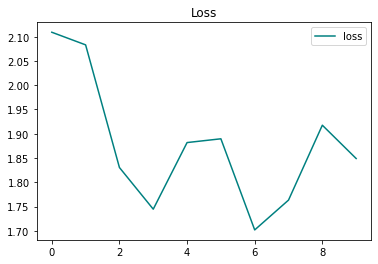

In [ ]:

plt.plot(hist.history['total_loss'], color='teal', label='loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
facetracker.save('facetracker.h5')